In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import cv2
from tqdm import tqdm
import shutil
import yaml
from skimage.segmentation import expand_labels

In [81]:
map_cfg_path = "mappings/df_map_sans_torso.yaml"
map_cfg_path = "mappings/df_map_with_torso.yaml"
map_cfg_path = "mappings/df_map_sep.yaml"

# Open and load YAML file
with open(map_cfg_path, "r") as file:
    mappings = yaml.safe_load(file)   # safer than yaml.load

#Class mappings : (LIP -> Merged), (DeepFashion -> Merged)
segm_to_merged = mappings["segm_to_merged"]
dense_to_merged = mappings["densepose_to_merged"]

#Source mappings
segm_classes = mappings["segm_classes"]
merged_classes = mappings["lip_merged_classes"]

#Print keys
keys = list(mappings.keys())
keys = " - " + "\n - ".join(keys)
print(f"mappings keys : \n{keys}")

mappings keys : 
 - densepose_classes
 - segm_classes
 - lip_merged_classes
 - densepose_to_merged
 - segm_to_merged


### Class Mapping

#### Loading Data

In [82]:
dir_path = 'data/DeepFashion_Multi'

# im_dir = os.path.join(dir_path, 'DeepFashion_LIP/train_images')
# segm_dir = os.path.join(dir_path, 'DeepFashion_LIP/train_segmentations')

im_dir = os.path.join(dir_path, 'DeepFashion_LIP/val_images')
segm_dir = os.path.join(dir_path, 'DeepFashion_LIP/val_segmentations')

dense_dir = os.path.join(dir_path, 'densepose')

ids = [f.replace(".jpg", "") for f in os.listdir(im_dir)]
id = np.random.choice(ids)
# id = 'WOMEN-Rompers_Jumpsuits-id_00004457-01_4_full'
id

'WOMEN-Rompers_Jumpsuits-id_00004457-01_4_full'

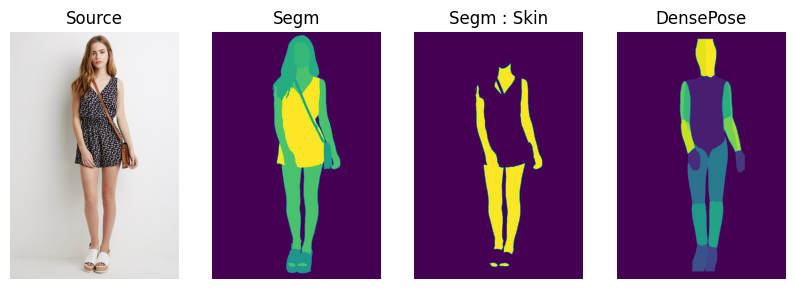

In [93]:
im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

segm_path = os.path.join(segm_dir, f"{id}_segm.png")
segm = np.array(Image.open(segm_path))

skin = segm == 15

dense_path = os.path.join(dense_dir, f"{id}_densepose.png")
dense = np.array(Image.open(dense_path))[:, :, 2]

fig, ax = plt.subplots(1, 4, figsize = (10, 5))
titles = ["Source", "Segm", "Segm : Skin", "DensePose"]

for i, plot_im in enumerate([im, segm, skin, dense]):
    ax[i].imshow(plot_im)
    ax[i].set_axis_off()
    ax[i].set_title(titles[i])

#### Class Mapping pipeline

In [84]:
def get_lookup(mapping):

    lookup = np.arange(len(mapping))
    for k, v in mapping.items():
        lookup[k] = v

    return lookup

def DeepFashion_mapping(segm, dense, 
                        segm_map_lookup, dense_map_lookup,
                        skin_label=15, expand_px=10):
    
    #Mapping
    segm_mapped = segm_map_lookup[segm]
    dense_mapped = dense_map_lookup[dense]

    #Mapping skin to distinct labels
    segm_skin = (segm == skin_label)
    dense_mapped_expand = expand_labels(dense_mapped, distance=expand_px)

    skin_distinct = np.where(segm_skin, dense_mapped_expand, 0)
    
    #Merge the result with segmentation
    result = np.where(segm_mapped == 15, skin_distinct, segm_mapped)
    return result


In [85]:
segm_map_lookup = get_lookup(segm_to_merged)
dense_map_lookup = get_lookup(dense_to_merged)

segm_result = DeepFashion_mapping(segm, dense,
                                  segm_map_lookup, dense_map_lookup)

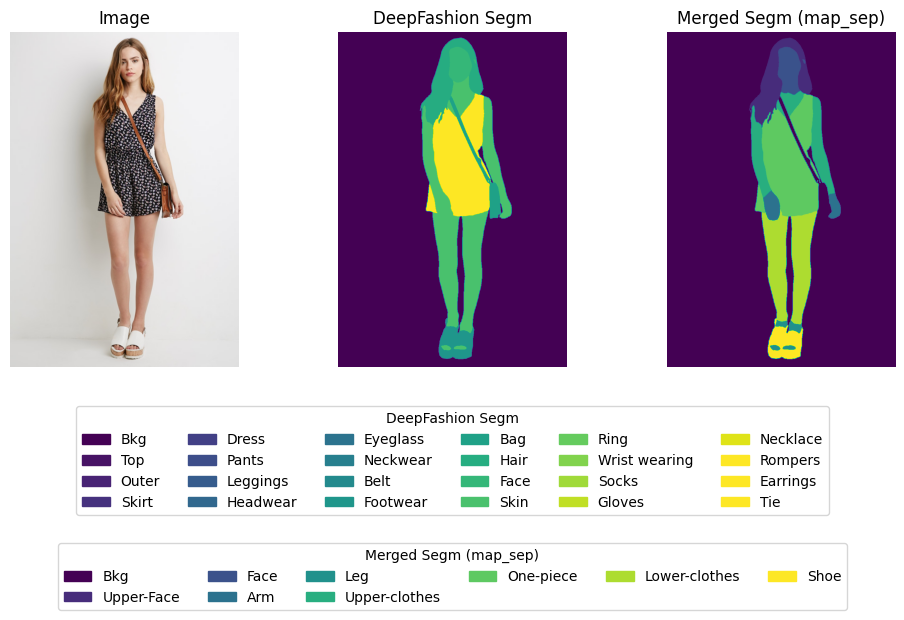

In [ ]:
from matplotlib.patches import Patch

get_handle = lambda class_labels, cmap, norm: [
    Patch(color=cmap(norm(idx)), label=label)
    for idx, label in class_labels.items()
]

fig, ax = plt.subplots(1, 3, figsize = (10, 5))

plots = [im, segm, segm_result]
titles = ["Image", "DeepFashion Segm", "Merged Segm (map_sep)"]
classes = [None, segm_classes, merged_classes]
legend_pos = [None, "lower center", "lower center"]
legend_bbox = [None, (0.5, -0.01), (0.5, -0.2)]

for i in range(len(plots)):
    info = ax[i].imshow(plots[i])

    #Plot Legend for (Segm, Merged)
    if i > 0:
        cmap, norm = info.cmap, info.norm
        handle = get_handle(classes[i], cmap, norm)

        fig.legend(
            handles=handle, title=titles[i],
            loc=legend_pos[i], 
            bbox_to_anchor=legend_bbox[i], 
            ncol=6
        )

    ax[i].set_axis_off()
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)


# file_name = "demo/df_map_sep.png"
# plt.savefig(file_name, bbox_inches="tight")

plt.show()